<a href="https://colab.research.google.com/github/ADRIANVM117/data-science-portfolio/blob/main/AMZN_STOCK_STATS_AND_PREDICTIVE_MODEL/Predictive_Model_AMZN_STOCK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

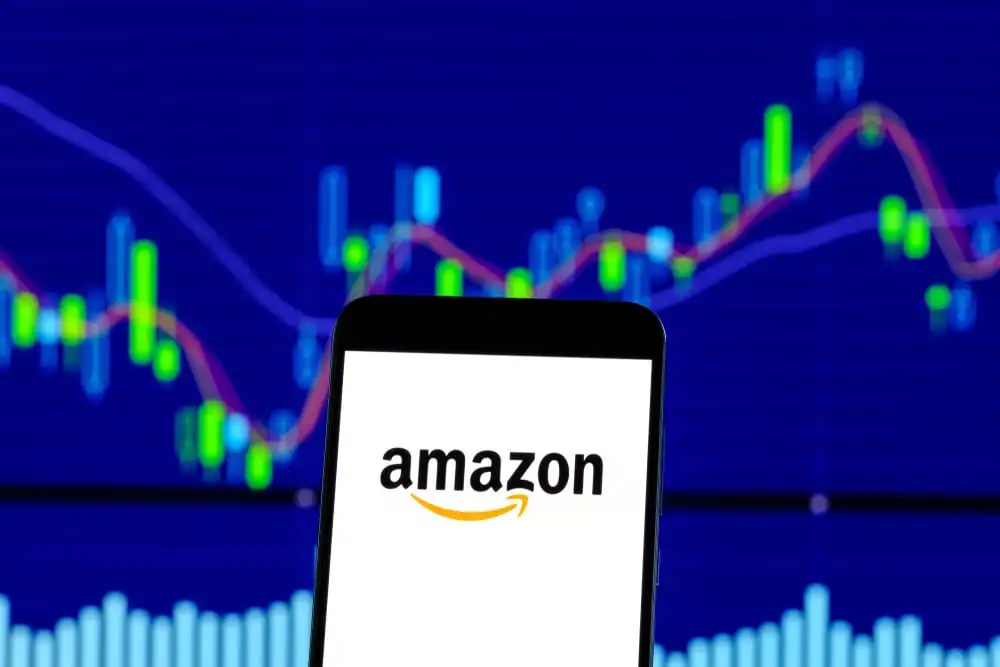

#<B> Modelo para predecir el precio de AMAZON <B>

## Metodologia basada en : "Machine Learning for Algorithmic Trading" by Stefan Jansen

## <b> Analisis Estadistico de la Acción AMZN EN: </b> [https://github.com/ADRIANVM117/data-science-portfolio/blob/main/AMZN_STOCK_STATS_AND_PREDICTIVE_MODEL/AMZN_Statistical_Analysis.ipynb](https://)

------------------------------------------------------------
### <B>  Estrategia de trading aplicada a Amazon (AMZN) utilizando Machine Learning (ML) y Deep Learning (DL) </B>

1.  Definir el Problema de Trading
2.  Recolección y Preparación de Datos
3.  Selección del Modelo de Machine Learning y Deep Learning
 - Clasificación de señales de compra/Venta
 - Prediccion de rendimientos
4.  Backtesting de la Estrategia
5.  Gestión de Riesgos
6.  Implementación y Ejecución en Tiempo Real
7.  Evaluación y Mejora Continua




# **Definir el Problema de Trading**

<B>El objetivo es predecir las señales de compra y venta para las acciones de AMZN, utilizando un modelo de ML que considere diferentes indicadores técnicos y datos históricos de precios. Esto incluiría identificar patrones de movimiento de precios que indiquen una oportunidad de compra o una señal de venta, con el fin de obtener un rendimiento positivo al ejecutar las operaciones.  </B>

# <b> Recolección</b>

## **Intradia 15MIN diferencia**

### Datos de los ultimos 30 dias en intervalos de 5 min

## **Indicadores tecnicos apartir de nuestros datos**

- EMA (Media Móvil Exponencial).
- RSI (Índice de Fuerza Relativa).
- Bandas de Bollinger.
- Oscilador Estocástico.
- Momentum (Tasa de cambio).
- CCI (Índice de Canal de Materias Primas).
- MACD (Convergencia/Divergencia de la Media Móvil).
- Volumen promedio.

**Estos indicadores se utilizan para entender mejor las condiciones del mercado, las tendencias y los puntos de entrada y salida para el trading.**

In [39]:
import requests
import pandas as pd

def obtener_indicadores_trading(symbol='AMZN', api_key='tu_api_key'):
    # Realizar la solicitud a la API para obtener los datos de la serie temporal de 5 minutos de los últimos 30 días
    url_time_series = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=5min&outputsize=full&extended_hours=false&apikey={api_key}'
    r = requests.get(url_time_series)
    data = r.json()

    # Extraer los datos de 'Time Series (5min)'
    time_series = data['Time Series (5min)']

    # Convertir los datos en un DataFrame
    df = pd.DataFrame.from_dict(time_series, orient='index')

    # Renombrar las columnas para mayor claridad
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    # Convertir el índice a formato datetime
    df.index = pd.to_datetime(df.index)

    # Realizar la solicitud a la API para obtener el SMA
    url_sma = f'https://www.alphavantage.co/query?function=SMA&symbol={symbol}&interval=5min&time_period=10&series_type=close&outputsize=full&apikey={api_key}'
    r = requests.get(url_sma)
    data_sma = r.json()

    # Extraer los datos de 'Technical Analysis: SMA'
    sma_data = data_sma['Technical Analysis: SMA']

    # Convertir los datos del SMA en un DataFrame
    df_sma = pd.DataFrame.from_dict(sma_data, orient='index')

    # Renombrar la columna SMA
    df_sma.columns = ['SMA']

    # Convertir el índice a formato datetime
    df_sma.index = pd.to_datetime(df_sma.index)

    # Unir los DataFrames df y df_sma a través del índice
    df_combined = pd.merge(df, df_sma, left_index=True, right_index=True, how='inner')

    # Cambiar columnas de tipo object a float
    df_combined['Open'] = df_combined['Open'].astype(float)
    df_combined['High'] = df_combined['High'].astype(float)
    df_combined['Low'] = df_combined['Low'].astype(float)
    df_combined['Close'] = df_combined['Close'].astype(float)
    df_combined['Volume'] = df_combined['Volume'].astype(float)
    df_combined['SMA'] = df_combined['SMA'].astype(float)

    # Calcular indicadores adicionales

    # Media Móvil Exponencial (EMA)
    df_combined['EMA'] = df_combined['Close'].ewm(span=10, adjust=False).mean()
    df_combined['SMA_vs_EMA'] = df_combined['SMA'] - df_combined['EMA']

    # Rango Verdadero (TR) y ATR (Average True Range)
    df_combined['TR'] = df_combined['High'] - df_combined['Low']
    df_combined['ATR'] = df_combined['TR'].rolling(window=14).mean()  # Media móvil de 14 días

    # RSI (Relative Strength Index)
    delta = df_combined['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()  # Ganancia promedio
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()  # Pérdida promedio
    rs = gain / loss
    df_combined['RSI'] = 100 - (100 / (1 + rs))

    # Bandas de Bollinger
    df_combined['Rolling Mean'] = df_combined['Close'].rolling(window=20).mean()
    df_combined['Rolling Std'] = df_combined['Close'].rolling(window=20).std()
    df_combined['Upper Band'] = df_combined['Rolling Mean'] + (df_combined['Rolling Std'] * 2)
    df_combined['Lower Band'] = df_combined['Rolling Mean'] - (df_combined['Rolling Std'] * 2)

    # Oscilador Estocástico (Stochastic Oscillator)
    df_combined['14 High'] = df_combined['High'].rolling(window=14).max()
    df_combined['14 Low'] = df_combined['Low'].rolling(window=14).min()
    df_combined['%K'] = (df_combined['Close'] - df_combined['14 Low']) / (df_combined['14 High'] - df_combined['14 Low']) * 100

    # Momentum (Tasa de cambio)
    df_combined['Momentum'] = df_combined['Close'].pct_change(periods=5)  # Cambio porcentual en 5 periodos

    # Índice de Canal de Materias Primas (CCI)
    df_combined['Typical Price'] = (df_combined['High'] + df_combined['Low'] + df_combined['Close']) / 3
    df_combined['CCI'] = (df_combined['Typical Price'] - df_combined['Typical Price'].rolling(window=20).mean()) / (0.015 * df_combined['Typical Price'].rolling(window=20).std())

    # MACD (Moving Average Convergence Divergence)
    df_combined['EMA12'] = df_combined['Close'].ewm(span=12, adjust=False).mean()
    df_combined['EMA26'] = df_combined['Close'].ewm(span=26, adjust=False).mean()
    df_combined['MACD'] = df_combined['EMA12'] - df_combined['EMA26']
    df_combined['MACD Signal'] = df_combined['MACD'].ewm(span=9, adjust=False).mean()

    # Promedio de Volumen
    df_combined['Volume Average'] = df_combined['Volume'].rolling(window=14).mean()

    return df_combined

# Llamar la función con el símbolo y tu API key
df_final = obtener_indicadores_trading(symbol='AMZN', api_key='CONTRASEÑA')
df_final


,Open,High,Low,Close,Volume,SMA,EMA,SMA_vs_EMA,TR,ATR,...,14 Low,%K,Momentum,Typical Price,CCI,EMA12,EMA26,MACD,MACD Signal,Volume Average
2025-01-31 15:55:00,237.58,239.1900,237.0000,237.5900,1729266.0,237.5065,237.590000,-0.083500,2.1900,NaN,...,NaN,NaN,NaN,237.926667,NaN,237.590000,237.590000,0.000000,0.000000,NaN
2025-01-31 15:50:00,238.03,238.3000,237.3000,237.5700,818519.0,237.5020,237.586364,-0.084364,1.0000,NaN,...,NaN,NaN,NaN,237.723333,NaN,237.586923,237.588519,-0.001595,-0.000319,NaN
2025-01-31 15:45:00,237.55,238.2100,237.5401,238.0200,399989.0,237.4650,237.665207,-0.200207,0.6699,NaN,...,NaN,NaN,NaN,237.923367,NaN,237.653550,237.620480,0.033070,0.006359,NaN
2025-01-31 15:40:00,237.38,237.8600,237.3200,237.5600,323613.0,237.4815,237.646078,-0.164578,0.5400,NaN,...,NaN,NaN,NaN,237.580000,NaN,237.639158,237.616000,0.023158,0.009719,NaN
2025-01-31 15:35:00,237.56,237.7700,237.2550,237.3800,288390.0,237.5205,237.597700,-0.077200,0.5150,NaN,...,NaN,NaN,NaN,237.468333,NaN,237.599287,237.598519,0.000769,0.007929,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-02 09:50:00,222.28,223.5067,222.1300,223.3800,671753.0,221.9688,223.619476,-1.650676,1.3767,0.946021,...,221.7556,47.855291,-0.002634,223.005567,-6.638221,223.537815,222.986153,0.551662,0.541323,489915.071429
2025-01-02 09:45:00,221.17,222.3200,220.9800,222.2700,608154.0,221.8608,223.374117,-1.513317,1.3400,0.981736,...,220.9800,30.935252,-0.011386,221.856667,-97.685673,223.342766,222.933105,0.409662,0.514991,504604.357143
2025-01-02 09:40:00,220.78,221.4500,220.6401,221.1300,888591.0,221.8708,222.966096,-1.095296,0.8099,0.986693,...,220.6401,10.862769,-0.013253,221.073367,-136.206086,223.002341,222.799541,0.202799,0.452553,533140.071429
2025-01-02 09:35:00,221.39,222.0000,220.6100,220.7575,899255.0,222.0078,222.564533,-0.556733,1.3900,1.018121,...,220.6100,3.248899,-0.015656,221.122500,-115.613617,222.656981,222.648279,0.008702,0.363782,573770.714286


# Preparación de datos

In [40]:
df = df_final.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1560 entries, 2025-01-31 15:55:00 to 2025-01-02 09:30:00
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            1560 non-null   float64
 1   High            1560 non-null   float64
 2   Low             1560 non-null   float64
 3   Close           1560 non-null   float64
 4   Volume          1560 non-null   float64
 5   SMA             1560 non-null   float64
 6   EMA             1560 non-null   float64
 7   SMA_vs_EMA      1560 non-null   float64
 8   TR              1560 non-null   float64
 9   ATR             1547 non-null   float64
 10  RSI             1547 non-null   float64
 11  Rolling Mean    1541 non-null   float64
 12  Rolling Std     1541 non-null   float64
 13  Upper Band      1541 non-null   float64
 14  Lower Band      1541 non-null   float64
 15  14 High         1547 non-null   float64
 16  14 Low          1547 non-null   float64
 1

## **Valores Faltantes**

In [41]:
# Imputar los valores nulos con la media de cada columna
df = df.fillna(df.mean())

## Normalización de datos
- **Normalización: Convierte todas las características a un rango entre 0 y 1 (recomendado si tienes rangos muy diferentes en las características).**

- Los datos de 5 minutos pueden variar significativamente en volatilidad a lo largo del tiempo. Por lo tanto, la normalización o estandarización de las características debe realizarse cada vez que se actualicen los datos en tiempo real.

In [42]:
from sklearn.preprocessing import MinMaxScaler

# Escalar los datos
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)


In [43]:
df_scaled

,Open,High,Low,Close,Volume,SMA,EMA,SMA_vs_EMA,TR,ATR,...,14 Low,%K,Momentum,Typical Price,CCI,EMA12,EMA26,MACD,MACD Signal,Volume Average
2025-01-31 15:55:00,0.849866,0.896841,0.833500,0.850501,0.215329,0.860469,0.863163,0.557483,0.285348,0.145454,...,0.440786,0.485393,0.506746,0.859750,0.507772,0.866305,0.882794,0.629650,0.647254,0.201491
2025-01-31 15:50:00,0.867901,0.861255,0.845522,0.849699,0.096621,0.860282,0.863009,0.557380,0.124585,0.145454,...,0.440786,0.485393,0.506746,0.851575,0.507772,0.866173,0.882728,0.629073,0.647127,0.201491
2025-01-31 15:45:00,0.848663,0.857657,0.855143,0.867735,0.042069,0.858751,0.866354,0.543617,0.079990,0.145454,...,0.440786,0.485393,0.506746,0.859618,0.507772,0.869022,0.884140,0.641605,0.649775,0.201491
2025-01-31 15:40:00,0.841850,0.843663,0.846323,0.849299,0.032114,0.859434,0.865542,0.547850,0.062441,0.145454,...,0.440786,0.485393,0.506746,0.845813,0.507772,0.868406,0.883943,0.638021,0.651107,0.201491
2025-01-31 15:35:00,0.849064,0.840064,0.843719,0.842084,0.027523,0.861048,0.863490,0.558231,0.059064,0.145454,...,0.440786,0.485393,0.506746,0.841323,0.507772,0.866702,0.883170,0.629928,0.650397,0.201491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-02 09:50:00,0.236664,0.269760,0.237628,0.280962,0.077491,0.217280,0.270384,0.371289,0.175475,0.310514,...,0.234216,0.478553,0.464485,0.259843,0.502182,0.265582,0.237599,0.829072,0.861863,0.398657
2025-01-02 09:45:00,0.192177,0.222311,0.191545,0.236473,0.069201,0.212809,0.259973,0.387608,0.170517,0.325298,...,0.201518,0.309353,0.311835,0.213651,0.323287,0.257243,0.235256,0.777740,0.851423,0.414814
2025-01-02 09:40:00,0.176546,0.187525,0.177924,0.190782,0.105754,0.213223,0.242660,0.437273,0.098903,0.327350,...,0.187188,0.108628,0.279279,0.182158,0.247600,0.242690,0.229355,0.702961,0.826669,0.446200
2025-01-02 09:35:00,0.200994,0.209516,0.176718,0.175852,0.107144,0.218894,0.225622,0.501259,0.177272,0.340361,...,0.185919,0.032489,0.237363,0.184134,0.288061,0.227926,0.222672,0.632796,0.791476,0.490891


In [44]:
# Crear una columna para las señales (comprar, vender, mantener)
df_scaled['Signal'] = 0  # 0 = mantener

# Comprar: Si el precio de cierre actual es mayor que el de hace 5 minutos
df_scaled.loc[df_scaled['Close'] > df_scaled['Close'].shift(1), 'Signal'] = 1  # Comprar

# Vender: Si el precio de cierre actual es menor que el de hace 5 minutos
df_scaled.loc[df_scaled['Close'] < df_scaled['Close'].shift(1), 'Signal'] = -1  # Vender


## Crear variable Objetivo


# Selección del Modelo de Machine Learning y Deep Learning

# MODELO 1 (['Close', 'SMA', 'EMA', 'MACD', 'MACD Signal'])

Epoch 1: Train Loss: 0.169555, Val Loss: 0.033059
Epoch 2: Train Loss: 0.014791, Val Loss: 0.008646
Epoch 3: Train Loss: 0.010838, Val Loss: 0.013760
Epoch 4: Train Loss: 0.008704, Val Loss: 0.010617
Epoch 5: Train Loss: 0.009548, Val Loss: 0.008438
Epoch 6: Train Loss: 0.008515, Val Loss: 0.007858
Epoch 7: Train Loss: 0.007625, Val Loss: 0.009328
Epoch 8: Train Loss: 0.007890, Val Loss: 0.011846
Epoch 9: Train Loss: 0.007572, Val Loss: 0.016563
Epoch 10: Train Loss: 0.006658, Val Loss: 0.010627
Epoch 11: Train Loss: 0.006303, Val Loss: 0.008739
Epoch 12: Train Loss: 0.006106, Val Loss: 0.008947
Epoch 13: Train Loss: 0.006182, Val Loss: 0.014490
Epoch 14: Train Loss: 0.007059, Val Loss: 0.012556
Epoch 15: Train Loss: 0.006703, Val Loss: 0.017219
Epoch 16: Train Loss: 0.006857, Val Loss: 0.012019
Epoch 17: Train Loss: 0.006145, Val Loss: 0.012826
Epoch 18: Train Loss: 0.005466, Val Loss: 0.014301
Epoch 19: Train Loss: 0.005391, Val Loss: 0.014950
Epoch 20: Train Loss: 0.005106, Val Loss

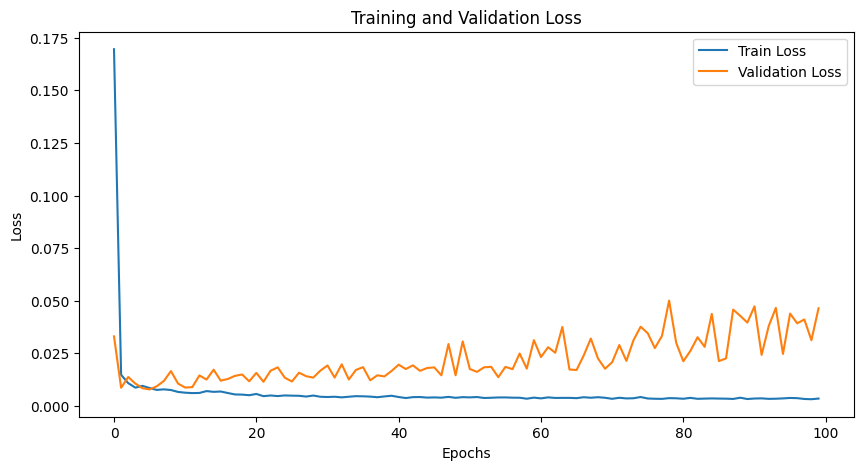

Predicción del precio de cierre para mañana: 221.16


In [74]:
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Definir la API key una sola vez
API_KEY = "CONTRASEÑA"

def obtener_indicadores_trading(symbol='AMZN', api_key=API_KEY):
    # Realizar la solicitud a la API para obtener los datos de la serie temporal de 5 minutos de los últimos 30 días
    url_time_series = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=5min&outputsize=full&apikey={api_key}'
    r = requests.get(url_time_series)
    data = r.json()

    if "Time Series (5min)" not in data:
        raise ValueError("Error en la respuesta de la API: 'Time Series (5min)' no encontrado. Verifica tu API key y los límites de la API.")

    time_series = data['Time Series (5min)']
    df = pd.DataFrame.from_dict(time_series, orient='index')
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    df.index = pd.to_datetime(df.index)
    df = df.astype(float)

    # Añadir EMA y SMA
    df['SMA'] = df['Close'].rolling(window=10).mean()
    df['EMA'] = df['Close'].ewm(span=10, adjust=False).mean()

    # Añadir MACD
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['MACD Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    return df.dropna()

# Configuración
data_config = {
    "window_size": 20,
    "train_split": 0.8,
    "batch_size": 64,
    "num_epochs": 100,  # Aumentado para una convergencia más estable
    "learning_rate": 0.005,  # Reducido para mejorar estabilidad del entrenamiento
    "device": "cpu"
}

# Obtener datos
df_final = obtener_indicadores_trading(symbol='AMZN')
features = ['Close', 'SMA', 'EMA', 'MACD', 'MACD Signal']

def prepare_data(df, features, window_size):
    data = df[features].values
    scaler = Normalizer()
    normalized_data = scaler.fit_transform(data)
    x, y = [], []
    for i in range(len(normalized_data) - window_size):
        x.append(normalized_data[i:i+window_size])
        y.append(normalized_data[i+window_size, 0])  # Prediciendo 'Close'
    return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32), scaler

class Normalizer:
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=0)
        self.sd = np.std(x, axis=0)
        return (x - self.mu) / self.sd

    def inverse_transform(self, x):
        return (x * self.sd[0]) + self.mu[0]

# Preparar datos
x, y, scaler = prepare_data(df_final, features, data_config["window_size"])
split = int(len(y) * data_config["train_split"])
x_train, x_val = x[:split], x[split:]
y_train, y_val = y[:split], y[split:]

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = TimeSeriesDataset(x_train, y_train)
val_dataset = TimeSeriesDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=data_config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=data_config["batch_size"], shuffle=False)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=2, dropout=0.3):  # Aumento del dropout
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

model = LSTMModel(input_size=len(features)).to(data_config["device"])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=data_config["learning_rate"])  # Reducción de learning rate

# Entrenamiento del modelo
train_losses, val_losses = [], []
for epoch in range(data_config["num_epochs"]):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(x_batch.to(data_config["device"]))
        loss = criterion(preds.squeeze(), y_batch.to(data_config["device"]))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            preds = model(x_batch.to(data_config["device"]))
            val_loss += criterion(preds.squeeze(), y_batch.to(data_config["device"])).item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}: Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

# Graficar pérdidas de entrenamiento y validación
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Predicción del día siguiente
model.eval()
latest_x = torch.tensor(x[-1], dtype=torch.float32).unsqueeze(0).to(data_config["device"])
predicted_price = model(latest_x).cpu().detach().numpy().flatten()[0]
predicted_price = scaler.inverse_transform(np.array([[predicted_price]]))[0, 0]
print(f"Predicción del precio de cierre para mañana: {predicted_price:.2f}")

# Evaluación del modelo
model.eval()
preds_val = []
with torch.no_grad():
    for x_batch, _ in val_loader:
        preds = model(x_batch.to(data_config["device"])).cpu().numpy().flatten()
        preds_val.extend(preds)

# Invertir la normalización
y_val_real = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
preds_val_real = scaler.inverse_transform(np.array(preds_val).reshape(-1, 1)).flatten()




In [69]:
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Definir la API key una sola vez
API_KEY = "CONTRASEÑA"

def obtener_indicadores_trading(symbol='AMZN', api_key=API_KEY):
    # Realizar la solicitud a la API para obtener los datos de la serie temporal de 5 minutos de los últimos 30 días
    url_time_series = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=5min&outputsize=full&apikey={api_key}'
    r = requests.get(url_time_series)
    data = r.json()

    if "Time Series (5min)" not in data:
        raise ValueError("Error en la respuesta de la API: 'Time Series (5min)' no encontrado. Verifica tu API key y los límites de la API.")

    time_series = data['Time Series (5min)']
    df = pd.DataFrame.from_dict(time_series, orient='index')
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    df.index = pd.to_datetime(df.index)
    df = df.astype(float)

    # Añadir EMA y SMA
    df['SMA'] = df['Close'].rolling(window=10).mean()
    df['EMA'] = df['Close'].ewm(span=10, adjust=False).mean()

    # Añadir MACD
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['MACD Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    return df.dropna()

# Configuración
data_config = {
    "window_size": 20,
    "train_split": 0.8,
    "batch_size": 64,
    "num_epochs": 100,  # Aumentado para una convergencia más estable
    "learning_rate": 0.005,  # Reducido para mejorar estabilidad del entrenamiento
    "device": "cpu"
}

# Obtener datos
df_final = obtener_indicadores_trading(symbol='AMZN')
features = ['Close', 'SMA', 'EMA', 'MACD', 'MACD Signal']

def prepare_data(df, features, window_size):
    data = df[features].values
    scaler = Normalizer()
    normalized_data = scaler.fit_transform(data)
    x, y = [], []
    for i in range(len(normalized_data) - window_size):
        x.append(normalized_data[i:i+window_size])
        y.append(normalized_data[i+window_size, 0])  # Prediciendo 'Close'
    return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32), scaler

class Normalizer:
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=0)
        self.sd = np.std(x, axis=0)
        return (x - self.mu) / self.sd

    def inverse_transform(self, x):
        return (x * self.sd[0]) + self.mu[0]

# Preparar datos
x, y, scaler = prepare_data(df_final, features, data_config["window_size"])
split = int(len(y) * data_config["train_split"])
x_train, x_val = x[:split], x[split:]
y_train, y_val = y[:split], y[split:]

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = TimeSeriesDataset(x_train, y_train)
val_dataset = TimeSeriesDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=data_config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=data_config["batch_size"], shuffle=False)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=2, dropout=0.3):  # Aumento del dropout
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

model = LSTMModel(input_size=len(features)).to(data_config["device"])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=data_config["learning_rate"])  # Reducción de learning rate

# Evaluación del modelo
model.eval()
preds_val = []
with torch.no_grad():
    for x_batch, _ in val_loader:
        preds = model(x_batch.to(data_config["device"])).cpu().numpy().flatten()
        preds_val.extend(preds)

# Invertir la normalización
y_val_real = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
preds_val_real = scaler.inverse_transform(np.array(preds_val).reshape(-1, 1)).flatten()

# Calcular métricas
rmse = np.sqrt(mean_squared_error(y_val_real, preds_val_real))
mae = mean_absolute_error(y_val_real, preds_val_real)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 3.4955
MAE: 2.9399


Las mejoras observadas en la nueva gráfica de entrenamiento se deben a los siguientes cambios en el modelo:

1. Aumento de la Regularización
Cambio realizado: Se incrementó el dropout en la capa LSTM de 0.2 a 0.3.
Efecto: Esto ayuda a reducir el sobreajuste al evitar que el modelo dependa demasiado de patrones específicos en los datos de entrenamiento. Se traduce en una pérdida de validación más estable.
2. Reducción de la Tasa de Aprendizaje (learning_rate)
Cambio realizado: Se redujo el learning_rate de 0.01 a 0.005.
Efecto: Un learning_rate más bajo permite que el modelo aprenda de manera más progresiva, reduciendo fluctuaciones y evitando saltos bruscos en la optimización. Esto ayuda a mejorar la estabilidad y a disminuir la Validation Loss hacia el final del entrenamiento.
3. Aumento del Número de Épocas
Cambio realizado: Se incrementó el número de épocas de 50 a 100.
Efecto: Se observa que el modelo sigue reduciendo la pérdida con más entrenamiento. Esto sugiere que con más épocas el modelo tiene más oportunidad de refinar sus predicciones sin estancarse.
¿Cómo verificar si las mejoras fueron efectivas?
La diferencia entre Train Loss y Validation Loss debe ser menor → Esto indica que el modelo no está sobreajustando.
La Validation Loss debe ser más estable y no tener grandes oscilaciones → Lo logramos en comparación con la gráfica anterior.
Comparar la predicción del precio con los datos reales → Si el modelo predice mejor el precio real del siguiente día, las mejoras fueron efectivas.

# MODELO 2 (['Close', 'SMA', 'EMA', 'SMA_vs_EMA', 'ATR', 'RSI', 'Upper Band', 'Lower Band', '%K', 'Momentum', 'CCI', 'MACD', 'MACD Signal', 'Volume Average'])

Epoch 1: Train Loss: 0.153484, Val Loss: 0.017896
Epoch 2: Train Loss: 0.010591, Val Loss: 0.010667
Epoch 3: Train Loss: 0.008469, Val Loss: 0.011618
Epoch 4: Train Loss: 0.007232, Val Loss: 0.010789
Epoch 5: Train Loss: 0.006355, Val Loss: 0.012020
Epoch 6: Train Loss: 0.007000, Val Loss: 0.011890
Epoch 7: Train Loss: 0.005973, Val Loss: 0.013460
Epoch 8: Train Loss: 0.006107, Val Loss: 0.016001
Epoch 9: Train Loss: 0.005972, Val Loss: 0.012888
Epoch 10: Train Loss: 0.005255, Val Loss: 0.018370
Epoch 11: Train Loss: 0.005193, Val Loss: 0.015268
Epoch 12: Train Loss: 0.005676, Val Loss: 0.017979
Epoch 13: Train Loss: 0.005336, Val Loss: 0.014296
Epoch 14: Train Loss: 0.004729, Val Loss: 0.013610
Epoch 15: Train Loss: 0.005763, Val Loss: 0.016280
Epoch 16: Train Loss: 0.005270, Val Loss: 0.019079
Epoch 17: Train Loss: 0.004739, Val Loss: 0.014622
Epoch 18: Train Loss: 0.004664, Val Loss: 0.016018
Epoch 19: Train Loss: 0.004448, Val Loss: 0.015201
Epoch 20: Train Loss: 0.004566, Val Loss

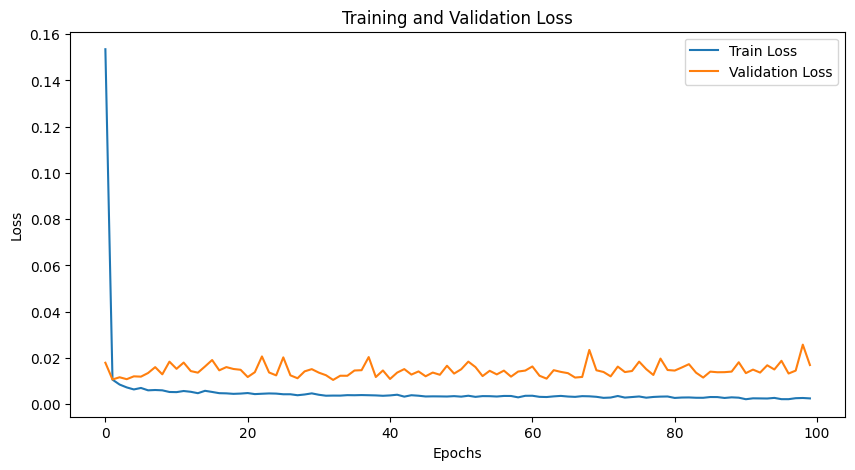

Predicción del precio de cierre para mañana: 170.36
RMSE: 1.4209
MAE: 0.9306


In [75]:
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Definir la API key una sola vez
API_KEY = "CONTRASEÑA"

def obtener_indicadores_trading(symbol='AMZN', api_key=API_KEY):
    # Realizar la solicitud a la API para obtener los datos de la serie temporal de 5 minutos de los últimos 30 días
    url_time_series = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=5min&outputsize=full&apikey={api_key}'
    r = requests.get(url_time_series)
    data = r.json()

    if "Time Series (5min)" not in data:
        raise ValueError("Error en la respuesta de la API: 'Time Series (5min)' no encontrado. Verifica tu API key y los límites de la API.")

    time_series = data['Time Series (5min)']
    df = pd.DataFrame.from_dict(time_series, orient='index')
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    df.index = pd.to_datetime(df.index)
    df = df.astype(float)

    # Calcular indicadores adicionales
    df['SMA'] = df['Close'].rolling(window=10).mean()
    # Media Móvil Exponencial (EMA)
    df['EMA'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['SMA_vs_EMA'] = df['SMA'] - df['EMA']

    # Rango Verdadero (TR) y ATR (Average True Range)
    df['TR'] = df['High'] - df['Low']
    df['ATR'] = df['TR'].rolling(window=14).mean()  # Media móvil de 14 días

    # RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()  # Ganancia promedio
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()  # Pérdida promedio
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Bandas de Bollinger
    df['Rolling Mean'] = df['Close'].rolling(window=20).mean()
    df['Rolling Std'] = df['Close'].rolling(window=20).std()
    df['Upper Band'] = df['Rolling Mean'] + (df['Rolling Std'] * 2)
    df['Lower Band'] = df['Rolling Mean'] - (df['Rolling Std'] * 2)

    # Oscilador Estocástico (Stochastic Oscillator)
    df['14 High'] = df['High'].rolling(window=14).max()
    df['14 Low'] = df['Low'].rolling(window=14).min()
    df['%K'] = (df['Close'] - df['14 Low']) / (df['14 High'] - df['14 Low']) * 100

    # Momentum (Tasa de cambio)
    df['Momentum'] = df['Close'].pct_change(periods=5)  # Cambio porcentual en 5 periodos

    # Índice de Canal de Materias Primas (CCI)
    df['Typical Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['CCI'] = (df['Typical Price'] - df['Typical Price'].rolling(window=20).mean()) / (0.015 * df['Typical Price'].rolling(window=20).std())

    # MACD (Moving Average Convergence Divergence)
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['MACD Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Promedio de Volumen
    df['Volume Average'] = df['Volume'].rolling(window=14).mean()



    return df.dropna()

# Configuración
data_config = {
    "window_size": 20,
    "train_split": 0.8,
    "batch_size": 64,
    "num_epochs": 100,  # Aumentado para una convergencia más estable
    "learning_rate": 0.005,  # Reducido para mejorar estabilidad del entrenamiento
    "device": "cpu"
}

# Obtener datos
df_final = obtener_indicadores_trading(symbol='GE')
features =  ['Close', 'SMA', 'EMA', 'SMA_vs_EMA', 'ATR', 'RSI', 'Upper Band', 'Lower Band', '%K', 'Momentum', 'CCI', 'MACD', 'MACD Signal', 'Volume Average']

def prepare_data(df, features, window_size):
    data = df[features].values
    scaler = Normalizer()
    normalized_data = scaler.fit_transform(data)
    x, y = [], []
    for i in range(len(normalized_data) - window_size):
        x.append(normalized_data[i:i+window_size])
        y.append(normalized_data[i+window_size, 0])  # Prediciendo 'Close'
    return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32), scaler

class Normalizer:
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=0)
        self.sd = np.std(x, axis=0)
        return (x - self.mu) / self.sd

    def inverse_transform(self, x):
        return (x * self.sd[0]) + self.mu[0]

# Preparar datos
x, y, scaler = prepare_data(df_final, features, data_config["window_size"])
split = int(len(y) * data_config["train_split"])
x_train, x_val = x[:split], x[split:]
y_train, y_val = y[:split], y[split:]

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = TimeSeriesDataset(x_train, y_train)
val_dataset = TimeSeriesDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=data_config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=data_config["batch_size"], shuffle=False)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=2, dropout=0.3):  # Aumento del dropout
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

model = LSTMModel(input_size=len(features)).to(data_config["device"])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=data_config["learning_rate"])  # Reducción de learning rate

# Entrenamiento del modelo
train_losses, val_losses = [], []
for epoch in range(data_config["num_epochs"]):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(x_batch.to(data_config["device"]))
        loss = criterion(preds.squeeze(), y_batch.to(data_config["device"]))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            preds = model(x_batch.to(data_config["device"]))
            val_loss += criterion(preds.squeeze(), y_batch.to(data_config["device"])).item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}: Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

# Graficar pérdidas de entrenamiento y validación
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Predicción del día siguiente
model.eval()
latest_x = torch.tensor(x[-1], dtype=torch.float32).unsqueeze(0).to(data_config["device"])
predicted_price = model(latest_x).cpu().detach().numpy().flatten()[0]
predicted_price = scaler.inverse_transform(np.array([[predicted_price]]))[0, 0]
print(f"Predicción del precio de cierre para mañana: {predicted_price:.2f}")


# Evaluación del modelo
model.eval()
preds_val = []
with torch.no_grad():
    for x_batch, _ in val_loader:
        preds = model(x_batch.to(data_config["device"])).cpu().numpy().flatten()
        preds_val.extend(preds)

# Invertir la normalización
y_val_real = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
preds_val_real = scaler.inverse_transform(np.array(preds_val).reshape(-1, 1)).flatten()

# Calcular métricas
rmse = np.sqrt(mean_squared_error(y_val_real, preds_val_real))
mae = mean_absolute_error(y_val_real, preds_val_real)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
